# Practico Clustering - Text Mining 2021

Garagiola, Nazareno


clustering is the process of grouping a set of
documents into clusters of similar documents


-> Preproceso: Lemmatizacion, catergoria morfosintactica (POS), etc

-> Hacer diferentes aproximacione spara categorizar palabras, por contexto en diferentes tamaños de ventanas

In [3]:
import spacy
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.manifold
from collections import Counter
%matplotlib inline

In [2]:
!python3 -m spacy download es_core_news_md > trash.txt
#!python3 -m spacy download es_core_news_sm



---



In [57]:
filename = "lavoztextodump.txt"
f = open(filename, 'r')
text = f.read()[:100000] #[:100000] 
text = text.replace('"', '')
text = text.replace('-\n', '\n')

In [58]:
# antes de correr esto, hay que correr la instalacion y resetear el runtime
nlp = spacy.load("es_core_news_md", vectores=False, entity=False)

lemmas = words = []
doc = nlp(text)
for token in doc:
    if len(token) > 1 and token.is_alpha: #alfabeticos e ignoro puntuaciones
        lemmas.append(token.lemma_.lower())
        words.append(token.text.lower())


In [59]:
counter_lemma = Counter(lemmas)
counter_words = Counter(words) #anecdotico nomas

Las triplas de dependencias son una forma de representar relaciones entre palabras. Si tengo una oración como "El gato come pescado", el análisis sintáctico de esa oración me dirá que gato es sujeto de comer, pescado es objeto de comer. Entonces, puedo representar la palabra gato diciendo que ocurrió una vez en el contexto X - sujeto - comer, y la palabra pescado diciendo que ocurrió una vez en el contexto X - objeto - comer. Entonces, mis dimensiones son estas triplas de la forma "Palabra objetivo - Función sintáctica - Otra palabra"

In [60]:
#most frequent words
MIN_FREQ = 10
most_freq = []
for w in counter_lemma:
    if (counter_lemma[w]>=MIN_FREQ):
        most_freq.append(w)
print(f"amount of words that appear more than {MIN_FREQ} times: {str(len(most_freq))}")

def word_filter(token):
    """
    Pequeña funcion que usaremos para filtrar las palabras
    """
    return (not token.is_alpha or token.is_digit or not token.lemma_ in most_freq)

amount of words that appear more than 10 times: 404


In [61]:
triplas = {}
tag = {}
pos = {}

for token in doc[1:]:
    #if not token.is_alpha or token.is_digit or counter_words[token.text] < word_threshold: continue
    if word_filter(token): continue
    triplas[token.text] = {}
    tag[token.text] = {}
    pos[token.text] = {}


In [62]:
for token in doc[1:-1]:
    #if not token.is_alpha or token.is_digit or counter_words[token.text] < word_threshold: continue
    if word_filter(token): continue
    i = token.i
    #notar que filtre el token, pero no el contexto del mismo
    span = doc[i - 1: i + 3]

    tripla = (f"obj: {token.text} - dep : {token.dep_} - nxt: {doc[i+1].lemma_}") # - context: {span}")
    if not tripla in triplas[token.text].keys():
        triplas[token.text][tripla] = 0
    triplas[token.text][tripla] += 1

    #triplas[token.text].append({token.i : tripla})

In [63]:
for token in doc[1:]:
    #if not token.is_alpha or token.is_digit or counter_words[token.text] < word_threshold: continue
    if word_filter(token): continue
    
    if not token.pos_ in pos[token.text].keys():
        pos[token.text][token.pos_] = 0
    pos[token.text][token.pos_] += 1

    if not token.tag_ in tag[token.text].keys():
        tag[token.text][token.tag_] = 0
    tag[token.text][token.tag_] += 1


In [64]:
feats = {}
for token in doc:
    #if not token.is_alpha or token.is_digit or counter_words[token.text] < word_threshold: continue
    if word_filter(token): continue
    word = token.text
    feats[word] = [tag[word], pos[word], triplas[word]]
    #feats[word] = [triplas[word]]

In [ ]:
feats

In [65]:
from sklearn.feature_extraction import DictVectorizer
# the class DictVectorizer can be used to convert feature arrays represented as 
# lists of standard Python dict objects to the NumPy/SciPy representation used
# by scikit-learn estimators.
vec = DictVectorizer(sparse=False)
features = []
for token in doc:
    #if not token.is_alpha or token.is_digit or counter_words[token.text] < word_threshold: continue
    if word_filter(token): continue
    word = token.text
    features += feats[word]

matrix = vec.fit_transform(X=features)

In [66]:
matrix_normed = matrix / matrix.max(axis=0)
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

threshold_variances = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_variances), axis=1)

In [ ]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, n_iter=250) #ultimo param para que sea mas rapido
matrix_dicc2d = tsne.fit_transform(red_matrix)
matrix_dicc2d.shape

In [16]:
#np.hstack((matrix_dicc2d, most_freq))
tagged_matrix = []
for i in range(len(most_freq)):
    tagged_matrix.append([matrix_dicc2d[i][0],matrix_dicc2d[i][1],most_freq[i]])

#tagged_matrix

In [17]:
df = pd.DataFrame(data= tagged_matrix, columns=['dim1','dim2',"word"] )
df.head(5)

,dim1,dim2,word
0,-0.480308,-4.359242,que
1,0.931392,-2.114954,el
2,-9.342211,6.438734,no
3,-6.376295,-4.003664,me


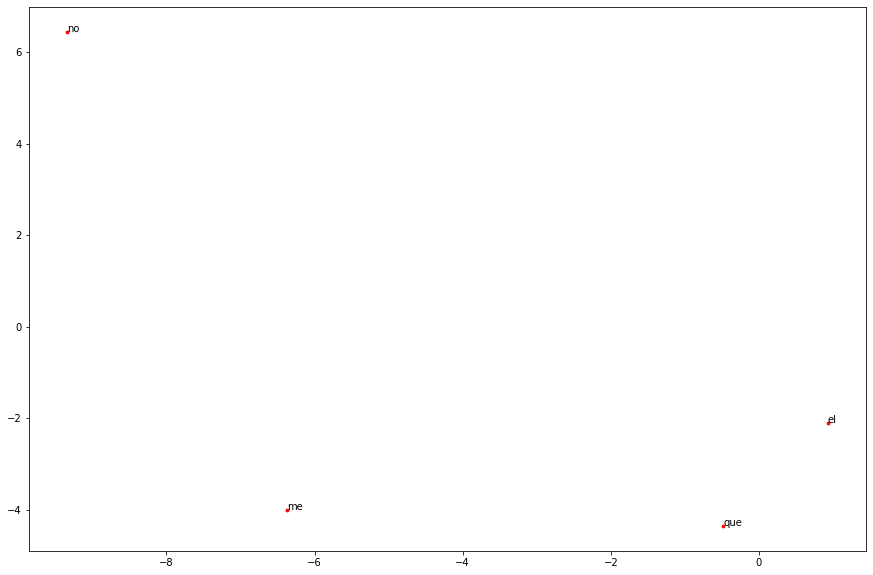

In [56]:
#g = df.plot.scatter(x="dim1", y="dim2", s=8, figsize=(12,10), c="red", label = "word")
#h = plt.scatter(x=df['dim1'],y=df['dim2'], s=8)
plt.figure(figsize=(15, 10))
plt.scatter(x=df['dim1'],y=df['dim2'], s=8, c="red")
for i, txt in enumerate(most_freq):
    plt.annotate(txt, (df['dim1'][i], df['dim2'][i]))

plt.show()

In [21]:
from nltk.cluster import kmeans, cosine_distance
def clustering(k):
    """
    k -> Cantidad de clusterers
    """
    clusterer = kmeans.KMeansClusterer(num_means=k, distance=cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [26]:
c50 =  clustering(50)
#other = tsne.fit_transform(red_matrix)
#other.shape

4

In [48]:
aux = [(matrix_dicc2d[i], c50[i], most_freq[i]) for i in range(len(most_freq))]

df_clustered = pd.DataFrame(
    [
        (coords[0], coords[1], cluster, word)
        for coords, cluster, word in aux
    ],
    columns=["dim1", "dim2", "cluster", "word"]
)

In [49]:
df_clustered.head(5)

,dim1,dim2,cluster,word
0,-0.480308,-4.359242,8,que
1,0.931392,-2.114954,3,el
2,-9.342211,6.438734,4,no
3,-6.376295,-4.003664,5,me


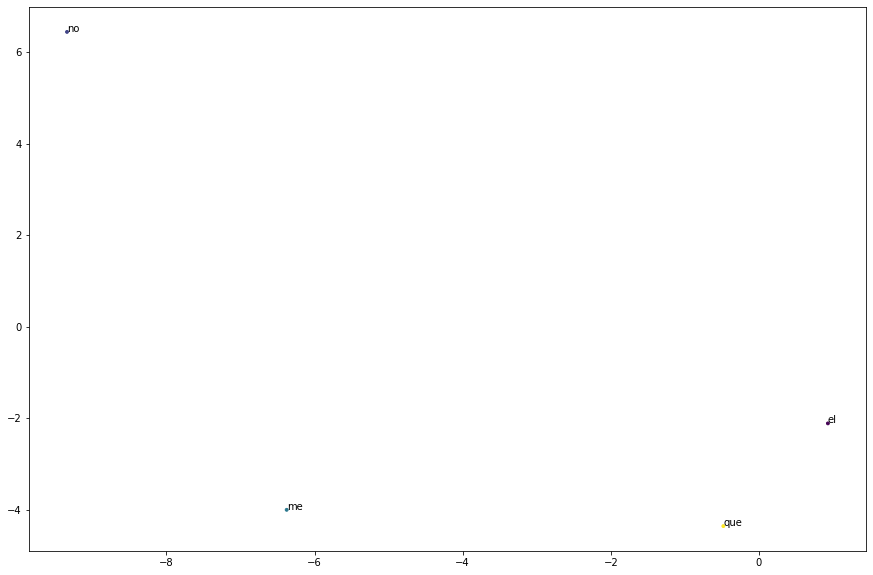

In [55]:
plt.figure(figsize=(15, 10))
plt.scatter(x=df_clustered['dim1'],y=df_clustered['dim2'], s=8, c=df_clustered['cluster'])
for i, txt in enumerate(most_freq):
    plt.annotate(txt, (df_clustered['dim1'][i], df_clustered['dim2'][i]))

plt.show()